# Лабораторна робота №2

## Тема: "Побудова та оцiнювання якостi моделей класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python"

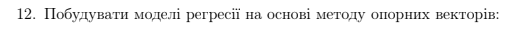
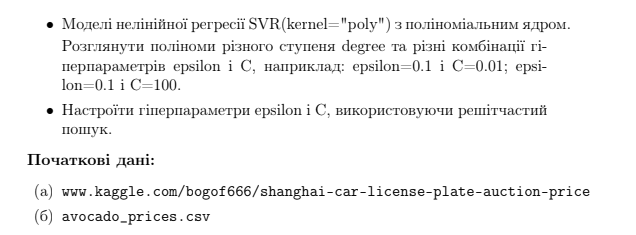

In [2]:
#Завантажуємо необхідні для виконання лабораторної роботи бібліотеки

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Почнемо виконання з датасету avocado_prices

In [3]:
#Завантажуємо наш датасет

avocado_prices = pd.read_csv(r"C:\Users\shink\Downloads\avocado_prices.csv", index_col='Unnamed: 0')

In [104]:
#Виводимо перші 5 рядків датасету
avocado_prices.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [105]:
#Перевіряємо типи змінних
avocado_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [106]:
#Перйменовуємо колонки для зручності
avocado_prices.rename(columns = {
    'Date' : 'date',
    'AveragePrice' : 'avg_price',
    'Total Volume' : 'total_volume',
    '4046' : 'total_s_hass',
    '4225' : 'total_l_hass',
    '4770' : 'total_xl_hass',
    'Total Bags' : 'total_bags',
    'Small Bags' : 's_bags',
    'Large Bags' : 'l_bags',
    'XLarge Bags': 'xl_bags'
}, inplace=True)

In [107]:
avocado_prices.date = pd.to_datetime(avocado_prices.date)

In [108]:
avocado_prices.loc[avocado_prices.total_bags == avocado_prices.s_bags + avocado_prices.l_bags + avocado_prices.xl_bags].shape

(14213, 13)

### Візуалізуємо дані

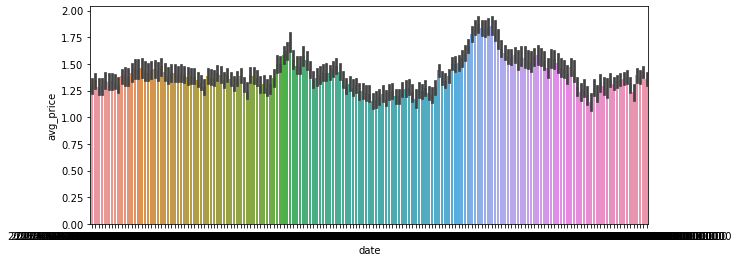

In [109]:
#Залежність середньої ціни від дати
plt.figure(figsize = (10,4))
sns.barplot(data = avocado_prices , x = 'date' , y = "avg_price")
plt.show()

In [110]:
avocado_prices.date.min()

Timestamp('2015-01-04 00:00:00')

In [111]:
avocado_prices.date.max()

Timestamp('2018-03-25 00:00:00')

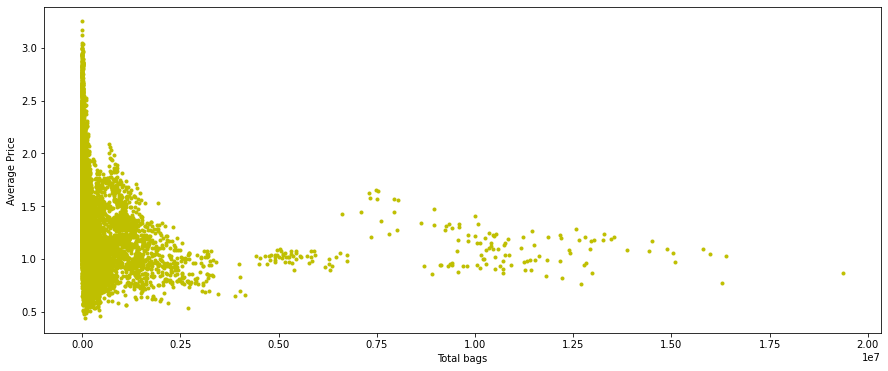

In [112]:
#Точковий графік залежності середньої ціни і total bags
plt.figure(figsize = (15,6))
plt.scatter(avocado_prices.total_bags, avocado_prices.avg_price, c = 'y', marker='.')
plt.xlabel('Total bags')
plt.ylabel('Average Price')
plt.show()

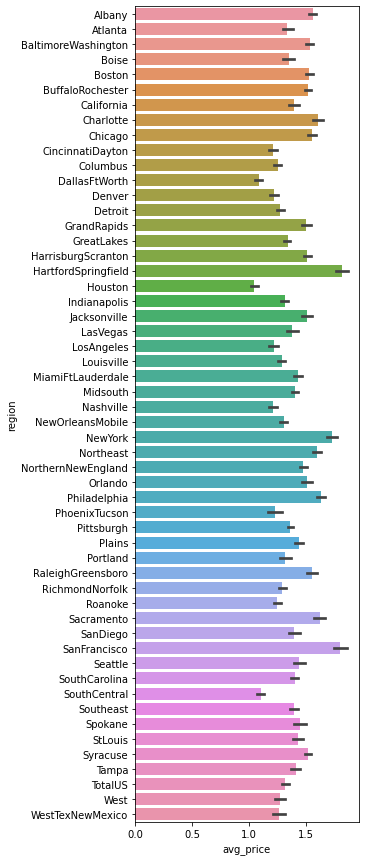

In [113]:
#Гістограма середньої ціни в залежності від регіону
plt.figure(figsize = (4,15))
sns.barplot(data = avocado_prices , x = 'avg_price' , y = "region", orient = 'h')
plt.show()

In [114]:
#Зробимо one-hot-encoding, адже SVR не приймає дані типу object
avocado_prices = pd.get_dummies(avocado_prices)


In [115]:
#Змінюємо дату на різницю поточного значення дати і мінімальної значення дати (у днях)
avocado_prices.date = (avocado_prices.date - avocado_prices.date.min()).apply(lambda x: x.days)

avocado_prices.rename(columns = {
    'date' : 'days_of_monitoring'
}, inplace = True)

In [48]:
avocado_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   days_of_monitoring          18249 non-null  int64  
 1   avg_price                   18249 non-null  float64
 2   total_volume                18249 non-null  float64
 3   total_s_hass                18249 non-null  float64
 4   total_l_hass                18249 non-null  float64
 5   total_xl_hass               18249 non-null  float64
 6   total_bags                  18249 non-null  float64
 7   s_bags                      18249 non-null  float64
 8   l_bags                      18249 non-null  float64
 9   xl_bags                     18249 non-null  float64
 10  year                        18249 non-null  int64  
 11  type_conventional           18249 non-null  uint8  
 12  type_organic                18249 non-null  uint8  
 13  region_Albany               18249 

In [49]:
'''Створюємо функцію, завдяки якій будемо для кожної моделi розраховувати критерiї якостi,
 окремо на навчальнiй та валiдацiйнiй множинах:'''
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

def metrics(X, y, model):
    print('R^2 : ', r2_score(y, model.predict(X)))
    print('RMSE: ', np.sqrt(mean_squared_error(y, model.predict(X))))
    print('MAPE: ', mean_absolute_percentage_error(y, model.predict(X)))
    print('MAE : ', mean_absolute_error(y, model.predict(X)))

### Побудуємо модель

##### Розіб'ємо дані на тренувальний та тестовий набори у відношенні 4:1

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_avocado = avocado_prices.drop(['avg_price'], axis = 1)
y_avocado = avocado_prices.avg_price

X_train_avocado, X_test_avocado, y_train_avocado, y_test_avocado = train_test_split(X_avocado,
                                                                                    y_avocado,
                                                                                    test_size = 0.2,
                                                                                    random_state = 42)

In [52]:
from sklearn.svm import SVR

In [116]:
#Створюємо модель
avocado_svr = SVR(kernel='poly')

In [84]:
#Навчання моделі
avocado_svr.fit(X_train_avocado, y_train_avocado)

SVR(kernel='poly')

In [88]:
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, avocado_svr)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, avocado_svr)

TRAIN SET
R^2 :  -0.0012158018552379524
RMSE:  0.4033589868669965
MAPE:  0.244697447799816
MAE :  0.3202574003830157
------------------------------
TEST SET
R^2 :  -0.004393413087453668
RMSE:  0.40171503453454754
MAPE:  0.24346289656087958
MAE :  0.3196858385953109


In [89]:
#Спробуємо створити модель з різними параметрами 
avocado_svr2 = SVR(kernel='poly', epsilon=0.1, C=100)
avocado_svr3 = SVR(kernel='poly', epsilon=0.1, C=0.01)
avocado_svr4 = SVR(kernel='poly', epsilon=0.01, C=10)
avocado_svr5 = SVR(kernel='poly', epsilon=0.01, C=1)

In [90]:
avocado_svr2.fit(X_train_avocado, y_train_avocado)
avocado_svr3.fit(X_train_avocado, y_train_avocado)
avocado_svr4.fit(X_train_avocado, y_train_avocado)
avocado_svr5.fit(X_train_avocado, y_train_avocado)

SVR(C=1, epsilon=0.01, kernel='poly')

In [91]:
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, avocado_svr2)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, avocado_svr2)

TRAIN SET
R^2 :  -18.519520942004075
RMSE:  1.780994044557262
MAPE:  0.363991987838958
MAE :  0.43919041607393106
------------------------------
TEST SET
R^2 :  -52.510352804372225
RMSE:  2.9321424476114677
MAPE:  0.43339423903731544
MAE :  0.4994776113982994


##### Можемо помітити перенавчання, так як отримуємо помітно гірші метрики на тренувальному наборі



In [92]:
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, avocado_svr3)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, avocado_svr3)

TRAIN SET
R^2 :  0.0004155353095532943
RMSE:  0.40303024517195135
MAPE:  0.246163910699924
MAE :  0.32112927629717314
------------------------------
TEST SET
R^2 :  -0.00378121619713645
RMSE:  0.4015925893961635
MAPE:  0.24450213795525325
MAE :  0.3200089034599911


In [93]:
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, avocado_svr4)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, avocado_svr4)

TRAIN SET
R^2 :  -0.3823297908934973
RMSE:  0.47395130530291874
MAPE:  0.25775409970501967
MAE :  0.3321742838130277
------------------------------
TEST SET
R^2 :  -0.7690759598610863
RMSE:  0.5331377052790894
MAPE:  0.2656159274208795
MAE :  0.34003443290260726


In [94]:
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, avocado_svr5)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, avocado_svr5)

TRAIN SET
R^2 :  -0.0018316671800884254
RMSE:  0.40348302437404043
MAPE:  0.24659587766065869
MAE :  0.3204047974580884
------------------------------
TEST SET
R^2 :  -0.00674757714363472
RMSE:  0.4021855421966071
MAPE:  0.24550661725337672
MAE :  0.3199046033235434


In [95]:
from sklearn.model_selection import GridSearchCV

In [117]:
#Спробуємо підібрати найкращу модель завдяки решітчатому пошуку
parameters = {'epsilon': [0.001, 0.01, 0.1], 'C': [0.1, 1.0, 10.0, 100.0]}
best_avocado = SVR(kernel='poly')
best_avocado = GridSearchCV(best_avocado, parameters, scoring='r2')

In [100]:
%%time
best_avocado.fit(X_train_avocado, y_train_avocado)  

Wall time: 3h 8min 11s


GridSearchCV(estimator=SVR(kernel='poly'),
             param_grid={'C': [0.1, 1.0, 10.0, 100.0],
                         'epsilon': [0.001, 0.01, 0.1]},
             scoring='r2')

In [65]:
import pickle
with open('best_avocado.sav', 'rb') as f:
    best_avocado = pickle.load(f)

In [66]:
#Параметри найкращої моделі
best_avocado

SVR(C=0.1, epsilon=0.001, kernel='poly')

In [67]:
#Метрики найкращої моделі
print('TRAIN SET')
metrics(X_train_avocado, y_train_avocado, best_avocado)
print('------------------------------')
print('TEST SET')
metrics(X_test_avocado, y_test_avocado, best_avocado)

TRAIN SET
R^2 :  0.0031342008247520203
RMSE:  0.40248179203677964
MAPE:  0.24579588475869693
MAE :  0.32071296269719063
------------------------------
TEST SET
R^2 :  -0.002547735309653021
RMSE:  0.4013457681531396
MAPE:  0.2444786861139564
MAE :  0.3199202117106843


### Другий дата сет

In [68]:
#Завантажуємо наш датасет
cars = pd.read_csv(r"D:\ИПСА\3 курс\ІАД\2 лаба\Shanghai license plate price - Sheet3.csv")

In [69]:
#Виводимо перші 5 рядків завантаженого датасету
cars.head()

,Date,Total number of license issued,lowest price,avg price,Total number of applicants
0,Jan-02,1400,13600,14735,3718
1,Feb-02,1800,13100,14057,4590
2,Mar-02,2000,14300,14662,5190
3,Apr-02,2300,16000,16334,4806
4,May-02,2350,17800,18357,4665


In [70]:
#Перевіряємо типи змінних
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Date                            204 non-null    object
 1   Total number of license issued  204 non-null    int64 
 2   lowest price                    204 non-null    int64 
 3   avg price                       204 non-null    int64 
 4   Total number of applicants      204 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.1+ KB


In [72]:
#Для зручності змінюємо назви колонок
cars.rename(columns = {
    'Date' : 'date',
    'Total number of license issued' : 'total_licences',
    'avg price' : 'avg_price',
    'lowest price' : 'lowest_price',
    'Total number of applicants' : 'total_applicants'
}, inplace=True)

In [73]:
#Також для зручності змінюємо формат року
cars.date.loc[cars['date'].apply(lambda x: "02" in str(x).lower())] = '2002'
cars.date.loc[cars['date'].apply(lambda x: "03" in str(x).lower())] = '2003'
cars.date.loc[cars['date'].apply(lambda x: "04" in str(x).lower())] = '2004'
cars.date.loc[cars['date'].apply(lambda x: "05" in str(x).lower())] = '2005'
cars.date.loc[cars['date'].apply(lambda x: "06" in str(x).lower())] = '2006'
cars.date.loc[cars['date'].apply(lambda x: "07" in str(x).lower())] = '2007'
cars.date.loc[cars['date'].apply(lambda x: "08" in str(x).lower())] = '2008'
cars.date.loc[cars['date'].apply(lambda x: "09" in str(x).lower())] = '2009'
cars.date.loc[cars['date'].apply(lambda x: "10" in str(x).lower())] = '2010'
cars.date.loc[cars['date'].apply(lambda x: "11" in str(x).lower())] = '2011'
cars.date.loc[cars['date'].apply(lambda x: "12" in str(x).lower())] = '2012'
cars.date.loc[cars['date'].apply(lambda x: "13" in str(x).lower())] = '2013'
cars.date.loc[cars['date'].apply(lambda x: "14" in str(x).lower())] = '2014'
cars.date.loc[cars['date'].apply(lambda x: "15" in str(x).lower())] = '2015'
cars.date.loc[cars['date'].apply(lambda x: "16" in str(x).lower())] = '2016'
cars.date.loc[cars['date'].apply(lambda x: "17" in str(x).lower())] = '2017'
cars.date.loc[cars['date'].apply(lambda x: "18" in str(x).lower())] = '2018'
cars.date.loc[cars['date'].apply(lambda x: "19" in str(x).lower())] = '2019'

In [74]:
cars.rename(columns = {'date' : 'year'}, inplace=True)
cars.year = cars.year.astype('int')

### Візуалізуємо дані

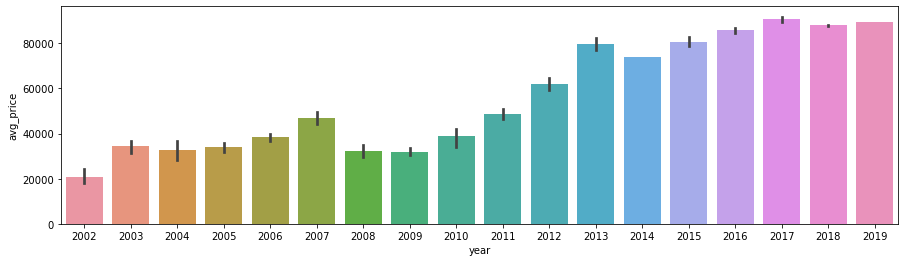

In [76]:
#Будуємо гістограму залежності середньої ціни від року
plt.figure(figsize = (15,4))
sns.barplot(data = cars , x = 'year' , y = "avg_price")
plt.show()

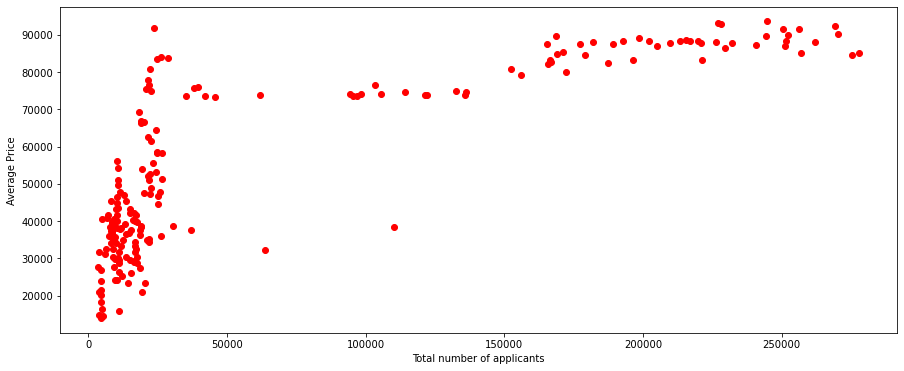

In [77]:
#Будуємо точковий графік залежності середньої ціни від кількості applicants
plt.figure(figsize = (15,6))
plt.scatter(cars.total_applicants, cars.avg_price, c = 'r')
plt.xlabel('Total number of applicants')
plt.ylabel('Average Price')
plt.show()

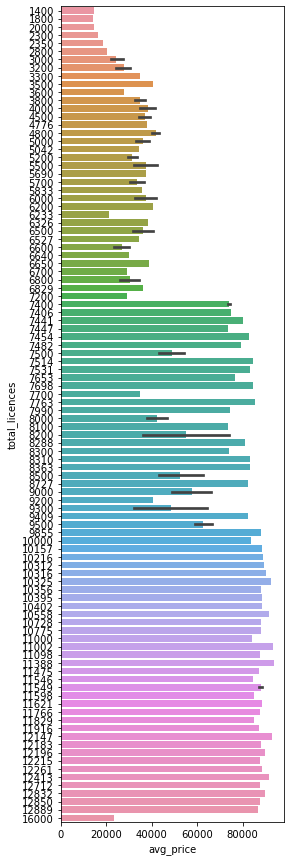

In [78]:
#Гістограма залежності ціни від кількості licences
plt.figure(figsize = (4,15))
sns.barplot(data = cars , y = 'total_licences' , x = "avg_price", orient='h')
plt.show()

##### Створимо навчальні і тренувальні набори різних розмірів

In [79]:
X_cars = cars.drop(['avg_price'], axis = 1)
y_cars = cars.avg_price

X_train_cars02, X_test_cars02, y_train_cars02, y_test_cars02 = train_test_split(X_cars,
                                                                                y_cars,
                                                                                test_size = 0.2,
                                                                                random_state = 42)

In [80]:
X_train_cars03, X_test_cars03, y_train_cars03, y_test_cars03 = train_test_split(X_cars,
                                                                                y_cars,
                                                                                test_size = 0.3,
                                                                                random_state = 42)

In [81]:
X_train_cars04, X_test_cars04, y_train_cars04, y_test_cars04 = train_test_split(X_cars,
                                                                                y_cars,
                                                                                test_size = 0.4,
                                                                                random_state = 42)

In [82]:
X_train_cars05, X_test_cars05, y_train_cars05, y_test_cars05 = train_test_split(X_cars,
                                                                                y_cars,
                                                                                test_size = 0.5,
                                                                                random_state = 42)

In [83]:
cars_svr02 = SVR(kernel='poly')

In [84]:
cars_svr02.fit(X_train_cars02, y_train_cars02)

SVR(kernel='poly')

In [85]:
print('TRAIN SET')
metrics(X_train_cars02, y_train_cars02, cars_svr02)
print('------------------------------')
print('TEST SET')
metrics(X_test_cars02, y_test_cars02, cars_svr02)

TRAIN SET
R^2 :  0.013091470015119011
RMSE:  23979.622398346353
MAPE:  0.40504563278039557
MAE :  19838.352270570285
------------------------------
TEST SET
R^2 :  -0.13500421077131408
RMSE:  23286.61027326586
MAPE:  0.328642926063601
MAE :  19124.07069629386


In [86]:
cars_svr03 = SVR(kernel='poly')

In [87]:
cars_svr03.fit(X_train_cars03, y_train_cars03)

SVR(kernel='poly')

In [88]:
print('TRAIN SET')
metrics(X_train_cars03, y_train_cars03, cars_svr03)
print('------------------------------')
print('TEST SET')
metrics(X_test_cars03, y_test_cars03, cars_svr03)

TRAIN SET
R^2 :  -0.0074820494862855025
RMSE:  24151.162668578563
MAPE:  0.40510850798030834
MAE :  19809.837160592833
------------------------------
TEST SET
R^2 :  -0.13776393606055248
RMSE:  24306.200245038908
MAPE:  0.3453423613110146
MAE :  19857.51727700073


In [89]:
cars_svr04 = SVR(kernel='poly')

In [90]:
cars_svr04.fit(X_train_cars04, y_train_cars04)

SVR(kernel='poly')

In [91]:
print('TRAIN SET')
metrics(X_train_cars04, y_train_cars04, cars_svr04)
print('------------------------------')
print('TEST SET')
metrics(X_test_cars04, y_test_cars04, cars_svr04)

TRAIN SET
R^2 :  -0.039311590279699216
RMSE:  25059.38891464959
MAPE:  0.41893463010571713
MAE :  20824.079120201604
------------------------------
TEST SET
R^2 :  -0.09056923263293104
RMSE:  23353.33455981228
MAPE:  0.3594652028152666
MAE :  18936.703910272234


In [92]:
cars_svr05 = SVR(kernel='poly')
cars_svr05.fit(X_train_cars05, y_train_cars05)
print('TRAIN SET')
metrics(X_train_cars05, y_train_cars05, cars_svr05)
print('------------------------------')
print('TEST SET')
metrics(X_test_cars05, y_test_cars05, cars_svr05)

TRAIN SET
R^2 :  -0.08133954482761574
RMSE:  25415.476967000915
MAPE:  0.41443056467459644
MAE :  21043.980095065275
------------------------------
TEST SET
R^2 :  -0.0833629412693846
RMSE:  23879.794022819882
MAPE:  0.3795544044563335
MAE :  19426.30390407699


In [93]:
'''У зв'язку з економією часу, в параметрах вкажемо найбільші значення, адже було знайдено, що алгоритм
дає кращі метрики при великих значеннях С і епсілон'''
from sklearn.model_selection import GridSearchCV
parameters = {'epsilon': [10, 100, 1000], 'C': [10**8, 10**9, 10**10]}

In [94]:
best_cars = SVR(kernel='poly')

In [95]:
best_cars = GridSearchCV(best_cars, parameters, scoring='neg_mean_squared_error')

In [ ]:
best_cars.fit(X_train_cars02, y_train_cars02) 

In [97]:
#Модель була збережена окремо, щоб не витрачати зайвий час на повторний запуск коду
import pickle
with open('best_cars.sav', 'rb') as f:
    best_cars = pickle.load(f)

In [98]:
#Найкращі параметри моделі
best_cars

SVR(C=100000000, epsilon=100, kernel='poly')

In [99]:
print('TRAIN SET')
metrics(X_train_cars02, y_train_cars02, best_cars)
print('------------------------------')
print('TEST SET')
metrics(X_train_cars02, y_train_cars02, best_cars)

TRAIN SET
R^2 :  0.9888757343010832
RMSE:  2545.889590727841
MAPE:  0.05246149214769543
MAE :  1552.6392273914703
------------------------------
TEST SET
R^2 :  0.9888757343010832
RMSE:  2545.889590727841
MAPE:  0.05246149214769543
MAE :  1552.6392273914703


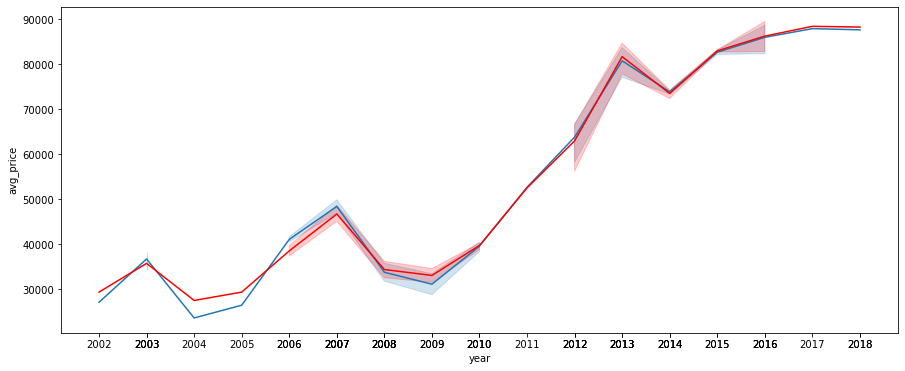

In [118]:
#Порівняння значень спрогнозованих та реальних даних
plt.figure(figsize = (15,6))
y_pred_cars = best_cars.predict(X_test_cars02)
x_ticks = X_test_cars02.year.tolist()
plot = sns.lineplot(x = X_test_cars02.year, y = y_test_cars02)
plot = sns.lineplot(x = X_test_cars02.year, y = y_pred_cars, color = "r")
plot.set_xticks(x_ticks);

### Висновок:

У ході виконання лабораторної роботи було побудовано дві моделі регресії на основі методу опорних векторів. Також була
побудована візуалізація даних, розбиття на тестовий та тренувальні набори, побудова самої моделі, підрахунок метрик, покращення
моделей задля уникнення перенавчання за допомогою решітчатого пошуку. Завдяки опрацюванню цієї лабораторної роботи я 
покращив свої знання у побудові та якості оцінювання моделей засобами бібліотеки Scikit-Learn Python.